<a href="https://colab.research.google.com/github/0x1beef/uap/blob/main/src/gimbal_clouds.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="https://kaggle.com/kernels/welcome?src=https://github.com/0x1beef/uap/blob/main/src/gimbal_clouds.ipynb">
    <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"   />
</a>

In [1]:
url = 'https://raw.githubusercontent.com/0x1beef/uap/main/src'
import urllib.request
for py_file in ['utils.py','common.py','opencv_cuda_installer.py']:
    urllib.request.urlretrieve(f'{url}/{py_file}', py_file)
import utils, common
is_main = (__name__ == '__main__')
from IPython.display import display

## **Download OpenCV built with CUDA support**

In [2]:
import opencv_cuda_installer as cv_cuda
utils.show_env_info()
use_opencv_cuda = %time cv_cuda.install_opencv_cuda()

No LSB modules are available.


Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.6 LTS
Release:	20.04
Codename:	focal
KAGGLE_DOCKER_IMAGE = gcr.io/kaggle-gpu-images/python@sha256:436e0a65b25fcc09cd6dbf95c9eff0e90121e967dee4f12a3009222e459da6db
Wed Jun 19 14:25:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /

opencv_cuda.tar.gz:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

extracting the opencv archive ...
checking if the dependencies have changed ...
uninstalling the old opencv ...
Found existing installation: opencv-python-headless 4.10.0.82
Uninstalling opencv-python-headless-4.10.0.82:
  Successfully uninstalled opencv-python-headless-4.10.0.82
Found existing installation: opencv-python 4.10.0.82
Uninstalling opencv-python-4.10.0.82:
  Successfully uninstalled opencv-python-4.10.0.82
Found existing installation: opencv-contrib-python 4.10.0.82
Uninstalling opencv-contrib-python-4.10.0.82:
  Successfully uninstalled opencv-contrib-python-4.10.0.82
installing the new opencv ...
testing the new opencv ...
  NVIDIA CUDA:                   YES (ver 12.1.105, CUFFT CUBLAS)
    NVIDIA GPU arch:             60 75
    NVIDIA PTX archs:
CPU times: user 566 ms, sys: 165 ms, total: 731 ms
Wall time: 13.1 s


## **Download the data (center of mass, horizon, video frames)**

In [3]:
utils.download_from_huggingface('logicbear/gimbal/data/object_data.parquet')

object_data.parquet:   0%|          | 0.00/40.9k [00:00<?, ?B/s]

In [4]:
(object_data, metadata) = utils.from_parquet_ext('data/object_data.parquet', 'gimbal')
center_of_mass = zip(object_data['center_of_mass_x'], object_data['center_of_mass_y'])
center_of_mass = [c for c in center_of_mass]
human_horizon = object_data['human_horizon']
object_data

,glare_angle,center_of_mass_x,center_of_mass_y,human_horizon
0,44.754770,211.832026,211.280392,-16.623859
1,44.774282,212.162427,210.585127,-16.628619
2,47.272436,212.630073,210.392548,-16.633649
3,48.072223,212.554429,210.332657,-16.703466
4,47.135192,212.736027,210.622222,-16.709074
...,...,...,...,...
1026,-63.289478,212.729350,210.701230,-29.707314
1027,-65.073287,212.761494,210.820690,-29.602813
1028,-65.246652,212.935252,210.872302,-29.599255
1029,-65.409900,213.052788,211.066429,-29.596001


In [5]:
%%time
gimbal = common.gimbal_from_huggingface()

2 - GIMBAL.wmv:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

ffmpeg -hide_banner -loglevel error -i "gimbal/2 - GIMBAL.wmv" -vf "format=gray, crop=428:428:104:27:exact=1" -vsync vfr -start_number 0 gimbal/frame_%04d.png
'gimbal': 1031 frames @ 29.97 fps
CPU times: user 54.3 ms, sys: 43 ms, total: 97.3 ms
Wall time: 5.88 s


## **Define a mask that only includes the clouds**

In [6]:
import cv2
import numpy as np
import math

def get_height_above_clouds(frame):
    time_dist_pairs = [
        (0, 25), (2, 30), (4, 30), (6, 30), (8, 50), (10, 45), (12, 40), (14, 55),
        (16, 45), (18, 40), (20, 40), (22, 45), (24, 50), (28, 55), (30, 60), (35, 60)
    ]
    time = gimbal.get_frame_time(frame)
    for ((t1,d1),(t2,d2)) in zip(time_dist_pairs, time_dist_pairs[1:]):
        if t2 > time:
            return d1 + (time - t1) * (d2 - d1) / (t2 - t1)
    return 0

def unit_vector(angle):
    return np.array((math.cos(angle), math.sin(angle)))

def get_cloud_top_point_angle(frame, height_offset):
    global human_horizon, center_of_mass
    horizon_angle = -math.radians(human_horizon[frame])
    height = get_height_above_clouds(frame) + height_offset
    com = np.array(center_of_mass[frame])
    cloud_top_point = com + unit_vector(horizon_angle + math.pi / 2) * height
    return (cloud_top_point, horizon_angle)

def get_cloud_top_border_intersections(frame, height_offset, frame_width):
    (cloud_top_point, horizon_angle) = get_cloud_top_point_angle(frame, height_offset)
    cloud_heading = unit_vector(horizon_angle)
    # (x,y) = cloud_top_point + cloud_heading * t
    t = lambda x : (x - cloud_top_point[0]) / cloud_heading[0]
    y = lambda x : cloud_top_point[1] + cloud_heading[1] * t(x)
    return (y(0),y(frame_width-1))

flow_masks = [
    (0,   373, 115, 427),
    (194, 412, 243, 427),
    (317, 393, 391, 427),
    (369, 256, 426, 323),
    (34,  194, 69,  207),
    (384, 346, 426, 359),
    (413, 318, 426, 386)
]
def get_full_flow_mask(frame, frame_shape, erode_size):
    (h,w) = frame_shape
    img_mask = np.full(frame_shape, 255, np.uint8)
    # exclude the overlay
    for (j0,i0,j1,i1) in flow_masks:
        img_mask[i0:i1,j0:j1] = 0
    # exclude the border
    cv2.rectangle(img_mask, (0,0), (w-1,h-1), color=0, thickness=1)
    # exclude everything above the cloud line
    (y0,y1) = get_cloud_top_border_intersections(frame, erode_size / 2, w)
    points = np.array([[0, 0], [w-1, 0], [w-1, int(y1)], [0, int(y0)]])
    cv2.fillPoly(img_mask, pts=[points], color=0)
    # erode to account for the pyrlk block size
    erode_kernel = np.ones((erode_size, erode_size), np.uint8) 
    img_mask = cv2.erode(img_mask, erode_kernel)
    return img_mask

In [7]:
import matplotlib.pyplot as plt
def show(*imgs):
    for img in imgs:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.show()

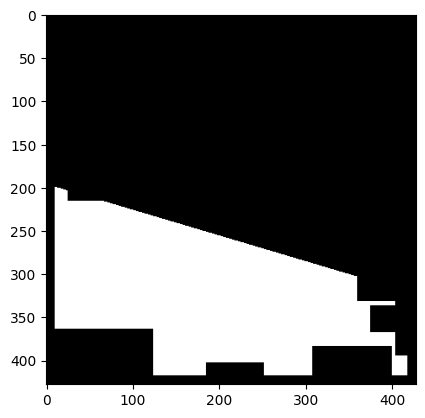

In [8]:
def test_flow_mask():
    erosion = 19
    frame = 0
    img_mask = get_full_flow_mask(frame, gimbal.get_frame(frame).shape, erosion)
    show(img_mask)
    
if is_main: test_flow_mask()

## **Test and run the cloud motion tracking algorithm**

In [9]:
from numba import njit
from dataclasses import dataclass

params_dict = {
    'frame_diff_from': 6,
    'frame_diff_to': 10,
    'erosion': 19,
    'min_mag': 1,
    'gftt': {
        'quality_level': 0.001,
        'block_size': 5,
        'min_dist': 0,
    },
    'pyrlk': {
        'block_size': 31,
        'max_level': 5,
        'iters': 100
    },
    'affine': {
        'threshold': 3,
        'max_iters': 2000,
        'confidence': 0.9999,
        'refine_iters': 10
    }
}

Params = utils.dict_to_obj(params_dict).__class__

def get_frame_diff(frame, par:Params):
    (fd_from, fd_to) = (par.frame_diff_from, par.frame_diff_to)
    num_frames = gimbal.get_frame_count()
    return int(fd_from + frame * (fd_to + 1 - fd_from) / num_frames)

def get_flow_roi(img):
    return img[136:]
def get_flow_roi_ofs():
    return (136, 0)

class CudaOpticalFlow:
    def init_mats(self, *mats):
        for mat in mats:
            setattr(self, mat, cv2.cuda.GpuMat())
    
    def __init__(self, par:Params):
        print(f'optical flow running on device {cv2.cuda.getDevice()}')
        self.stream = cv2.cuda.Stream()
        self.init_mats('gpu_img', 'gpu_mask', 'gpu_corners')
        pg = par.gftt
        self.cuda_gftt = cv2.cuda.createGoodFeaturesToTrackDetector(
            cv2.CV_8UC1, 0, pg.quality_level, pg.min_dist, pg.block_size, False)
        self.init_mats('gpu_img_next', 'gpu_corners_next')
        self.init_mats('gpu_status', 'gpu_error')
        pp = par.pyrlk
        self.cuda_pyrlk = cv2.cuda.SparsePyrLKOpticalFlow.create(
            (pp.block_size, pp.block_size), pp.max_level, pp.iters)
    
    def run(self, img, img_next, img_mask, par):
        self.gpu_img.upload(img, self.stream)
        self.gpu_img_next.upload(img_next, self.stream)
        self.gpu_mask.upload(img_mask, self.stream)
        self.gpu_corners = self.cuda_gftt.detect(self.gpu_img, self.gpu_corners, 
            self.gpu_mask, self.stream)
        (self.gpu_corners_next, self.gpu_status, self.gpu_error) = self.cuda_pyrlk.calc(
            self.gpu_img, self.gpu_img_next, self.gpu_corners,
            self.gpu_corners_next, self.gpu_status, self.gpu_error, self.stream)
        corners = self.gpu_corners.download(self.stream)[0]
        corners_next = self.gpu_corners_next.download(self.stream)[0]
        status = self.gpu_status.download(self.stream)[0]
        self.stream.waitForCompletion()
        return (corners, corners_next, status)

class OpticalFlow:
    def __init__(self, par:Params):
        pp = par.pyrlk
        self.pyrlk = cv2.SparsePyrLKOpticalFlow.create(
            (pp.block_size, pp.block_size), pp.max_level)
    
    def run(self, img, img_next, img_mask, par: Params):
        pg = par.gftt
        corners = cv2.goodFeaturesToTrack(img, 0, pg.quality_level,
            pg.min_dist, None, img_mask, pg.block_size, False)
        (corners_next, status, error) = self.pyrlk.calc(
            img, img_next, corners, None)
        corners = np.reshape(corners, (len(corners), 2))
        corners_next = np.reshape(corners_next, (len(corners_next), 2))
        return (corners, corners_next, status)
    
def make_flow_algorithm(par:Params):
    if use_opencv_cuda:
        return CudaOpticalFlow(par)
    else:
        return OpticalFlow(par)

@njit
def filter_map_flow_results_jit(c1, c2, status, img_mask, ofs, min_mag, c1out, c2out):
    (h,w) = img_mask.shape
    (ofs_y,ofs_x) = ofs
    def filter_map_status(i,j):
        if status[i] == 0:
            return (1,j)
        (x1,y1) = c1[i]
        (x2,y2) = c2[i]
        if not (x2 >= 0 and y2 >= 0 and x2 < w and y2 < h):
            return (2,j)
        if img_mask[int(y2), int(x2)] != 255:
            return (3,j)
        (dx,dy) = (x2-x1,y2-y1)
        mag = math.sqrt(dx*dx+dy*dy)
        if mag < min_mag:
            return (4,j)
        c1out[j] = (x1+ofs_x, y1+ofs_y)
        c2out[j] = (x2+ofs_x, y2+ofs_y)
        return (0,j+1)
    j = 0
    for i in range(len(c1)):
        (status[i],j) = filter_map_status(i,j)
    return j

#based on https://stackoverflow.com/questions/58422690/filtering-reducing-a-numpy-array
def filter_map_flow_results(c1, c2, status, img_mask, min_mag):
    ofs = get_flow_roi_ofs()
    c1out = np.empty_like(c1)
    c2out = np.empty_like(c2)
    j = filter_map_flow_results_jit(c1, c2, status, img_mask, ofs, min_mag, c1out, c2out)
    c1out.resize((j,2), refcheck=False)
    c2out.resize((j,2), refcheck=False)
    return (c1out, c2out, status)
    
def get_optical_flow(frame, frame_diff, par:Params, flow_algorithm):
    next_frame = frame + frame_diff
    if next_frame >= gimbal.get_frame_count():
        return ([],[],[])
    (img, img_next) = [gimbal.get_frame(f) for f in [frame, next_frame]]
    img_mask = get_full_flow_mask(frame, img.shape, par.erosion)
    (img, img_next, img_mask) = [get_flow_roi(i) for i in [img, img_next, img_mask]]
    (corners, corners_next, status) = flow_algorithm.run(img, img_next, img_mask, par)
    return filter_map_flow_results(corners, corners_next, status, img_mask, par.min_mag)

@njit
def get_inlier_mean(corners, inliers):
    (sum_x, sum_y, num_inliers) = (0.0, 0.0, 0)
    # todo: does this need to be more numerically stable ?
    for ((cx, cy), inlier) in zip(corners, inliers):
        if inlier:
            sum_x += float(cx); sum_y += float(cy)
            num_inliers += 1
    return np.array([sum_x / num_inliers, sum_y / num_inliers])

@dataclass
class CloudMotionData:
    frame: int; frame_diff: int
    magnitude: float; angle: float; rotation: float; transform: np.ndarray
    corners: np.ndarray; corners_next: np.ndarray; status: np.ndarray; inliers: np.ndarray
    c_inl_mean: float; cn_inl_mean: float

def get_cloud_motion(frame, frame_diff, corners, corners_next, status, par: Params):
    pa = par.affine
    (transform, inliers) = cv2.estimateAffinePartial2D(corners, corners_next, None,
        cv2.RANSAC, pa.threshold, pa.max_iters, pa.confidence, pa.refine_iters)
    rotation = math.degrees(math.atan2(transform[1, 0], transform[0, 0]))
    inliers = inliers.ravel() # from [[0],[1],...] to [0,1,...]
    c_inl_mean = get_inlier_mean(corners, inliers)
    cn_inl_mean = get_inlier_mean(corners_next, inliers)
    mean = cn_inl_mean - c_inl_mean
    magnitude = np.linalg.norm(mean) / frame_diff
    angle = math.degrees(math.atan2(mean[1], mean[0]))
    return CloudMotionData(frame, frame_diff,
        magnitude, angle, rotation, transform,
        corners, corners_next, status, inliers,
        c_inl_mean, cn_inl_mean)

def run_cloud_tracking_for(frames):
    par = Params()
    flow_algorithm = make_flow_algorithm(par)
    motions = []
    for frame in frames:
        frame_diff = get_frame_diff(frame, par)
        (corners, corners_next, status) = get_optical_flow(frame, frame_diff, par, flow_algorithm)
        if len(corners) != 0:
            motions.append(get_cloud_motion(frame, frame_diff, corners, corners_next, status, par))
    return motions

def get_cloud_frame_range():
    num_frames = gimbal.get_frame_count()
    if not use_opencv_cuda: # only do the last 1/10 the of the frames on the CPU
        return range(num_frames - int(num_frames/10), num_frames)
    return range(0, num_frames)

def run_cloud_tracking():
    return run_cloud_tracking_for(get_cloud_frame_range())

def run_cloud_tracking_parallel():
    return utils.run_jobs_in_parallel(work_func = run_cloud_tracking_for, 
        jobs = get_cloud_frame_range(), workers = 4, cv_cuda = True)

optical flow running on device 0
1240 1240
2.73554176774756 25.616793765339466 -1.686610963597804


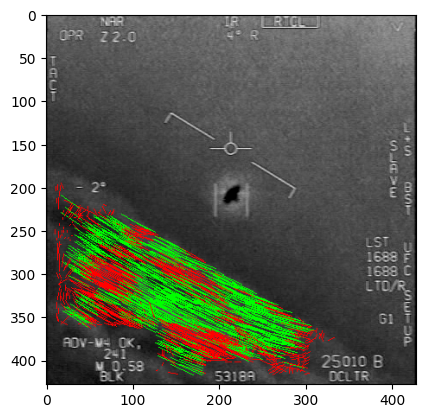

In [10]:
def show_flow(img, corners, corners_next, inliers):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for ((c1x,c1y), (c2x,c2y), inlier) in zip(corners, corners_next, inliers):
        color = (0,255,0) if inlier else (255, 0, 0)
        cv2.line(img_rgb, (int(c1x),int(c1y)), (int(c2x),int(c2y)), color, 1)
    plt.imshow(img_rgb)
    
def test_flow():
    par = Params()
    flow = make_flow_algorithm(par)
    frame = 980 #1000 # 5
    frame_diff = get_frame_diff(frame, par)
    (corners, corners_next, status) = get_optical_flow(frame, frame_diff, par, flow)
    print(len(corners), len(corners_next))
    m = get_cloud_motion(frame, frame_diff, corners, corners_next, status, par)
    print(m.magnitude, m.angle, m.rotation)
    show_flow(gimbal.get_frame(frame), corners, corners_next, m.inliers)
    
if is_main: test_flow()

In [11]:
if is_main:
    if use_opencv_cuda:
        cloud_motions = %time run_cloud_tracking_parallel()
    else: # the CPU version already uses multiple threads
        cloud_motions = %time run_cloud_tracking()
    print(len(cloud_motions))

optical flow running on device 1
optical flow running on device 0
optical flow running on device 0
optical flow running on device 1
CPU times: user 428 ms, sys: 150 ms, total: 578 ms
Wall time: 8.84 s
1021


## **Plot the data and save it all to a parquet file**

In [19]:
import pandas as pd
def get_df_motion(cloud_motions):
    df = pd.DataFrame.from_records([m.__dict__ for m in cloud_motions], index = ["frame"])
    df = df.sort_index() # the parallel results may be out of order
    df = common.gimbal_fix_wh_to_bh(df, ['magnitude', 'angle', 'rotation'])
    df.attrs['fps'] = gimbal.get_fps() # used to convert frame to time while plotting
    print(df.dtypes)
    display(df)
    return df

if is_main:
    df_motion = get_df_motion(cloud_motions)

frame_diff        int64
magnitude       float64
angle           float64
rotation        float64
transform        object
corners          object
corners_next     object
status           object
inliers          object
c_inl_mean       object
cn_inl_mean      object
dtype: object


,frame_diff,magnitude,angle,rotation,transform,corners,corners_next,status,inliers,c_inl_mean,cn_inl_mean
frame,,,,,,,,,,,
0,6,6.524966,15.845094,0.381220,"[[0.9941578875172695, -0.00661477223389726, 40...","[[146.0, 376.0], [268.0, 304.0], [61.0, 286.0]...","[[184.66833, 387.14697], [306.4596, 317.6474],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[172.3141891891892, 319.99831081081084]","[209.97642613746024, 330.6876716871519]"
1,6,6.541189,16.891068,0.487516,"[[1.0046296498952916, -0.008548360017778719, 3...","[[42.0, 316.0], [22.0, 358.0], [374.0, 374.0],...","[[78.52522, 326.83398], [24.407204, 360.66843]...","[0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, ...","[163.54884318766068, 319.91645244215937]","[201.10280965103894, 331.3198251797791]"
2,6,6.531801,16.899555,0.341652,"[[1.0073182396855205, -0.006006668192647864, 3...","[[153.0, 308.0], [155.0, 307.0], [362.0, 371.0...","[[189.40103, 317.98688], [190.70905, 317.06177...","[0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...","[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, ...","[159.58355795148248, 318.5323450134771]","[197.0819424477549, 329.92490753009315]"
3,6,6.463990,16.983106,0.412445,"[[1.0065991325122927, -0.007246157891830171, 3...","[[112.0, 243.0], [296.0, 373.0], [211.0, 366.0...","[[112.26856, 244.57349], [293.67245, 378.10904...","[0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[165.98333333333332, 321.5487179487179]","[203.0759393887642, 332.87710735614485]"
4,6,6.488121,16.561010,0.274798,"[[0.9987974251841343, -0.004790402727736432, 3...","[[217.0, 367.0], [224.0, 372.0], [30.0, 308.0]...","[[209.94748, 361.62396], [216.79204, 366.42487...","[0, 4, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, ...","[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[173.80521091811414, 319.01861042183623]","[211.11904689514313, 330.11470495560036]"
...,...,...,...,...,...,...,...,...,...,...,...
1016,10,0.894411,29.473540,-0.163204,"[[0.9999202853446038, 0.002848229424848739, 6....","[[169.0, 358.0], [125.0, 323.0], [238.0, 391.0...","[[177.20738, 362.47736], [132.44179, 327.01245...","[0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, ...","[135.47058823529412, 322.41628959276017]","[143.25718034338627, 326.81698566971863]"
1017,10,0.941963,29.603707,-0.000748,"[[1.0057434109779082, 1.3138299870423626e-05, ...","[[266.0, 405.0], [268.0, 406.0], [148.0, 339.0...","[[277.83612, 411.8554], [279.53793, 412.7442],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[141.50949050949052, 325.3766233766234]","[149.6995098102581, 330.02990282117787]"
1018,10,0.946893,29.558060,-0.059662,"[[0.9998986917339154, 0.001041201194525228, 7....","[[267.0, 404.0], [141.0, 339.0], [150.0, 340.0...","[[277.28693, 409.42535], [149.54993, 343.4132]...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","[140.23060796645703, 325.42138364779873]","[148.46721909281092, 330.0924585530343]"


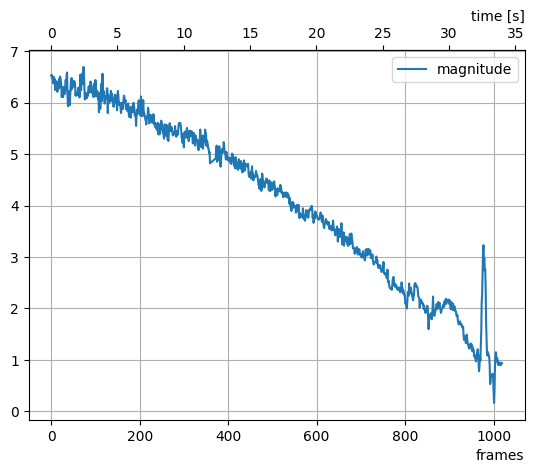

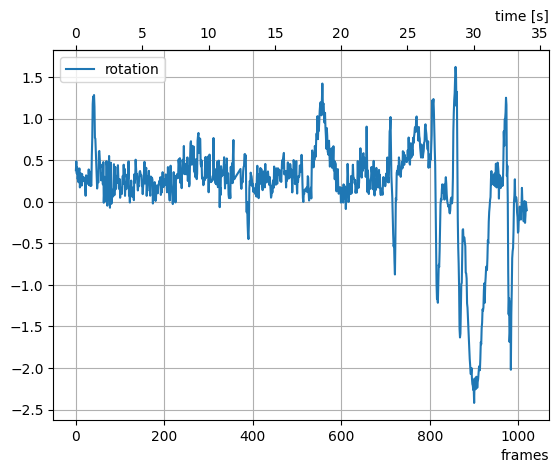

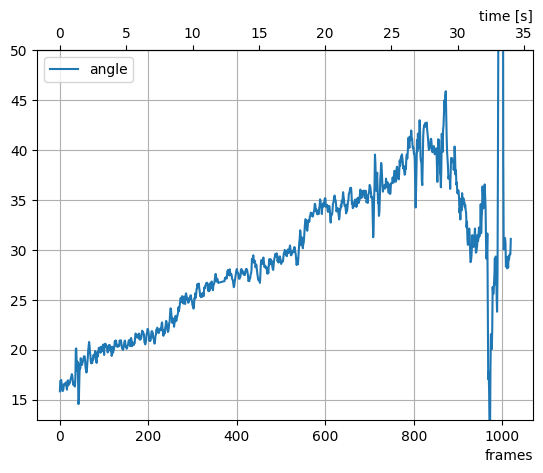

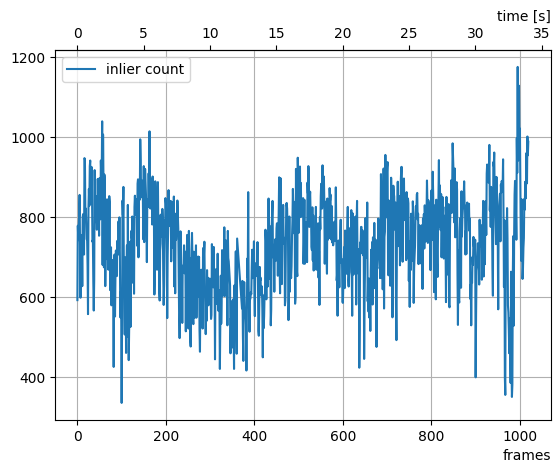

In [13]:
def plot_inliers(df, x_range):
    inlier_count = df.inliers.map(lambda i : np.sum(i))
    inlier_count[372-10:372] = np.nan
    inlier_count = inlier_count.interpolate()
    inlier_count[x_range].plot(label = 'inlier count', legend = True)
    
def plot_all():
    plot = common.plot_frame_data
    plot(df_motion, lambda df,xr: df.magnitude[xr].plot())
    plot(df_motion, lambda df,xr: df.rotation[xr].plot())
    plt.ylim(bottom=13, top=50)
    plot(df_motion, lambda df,xr: df.angle[xr].plot())
    plot(df_motion, plot_inliers)
    
if is_main:
    plot_all()

In [14]:
def test_flatten_ndarrays():
    (df_new, nd_shapes) = %time utils.flatten_ndarrays(df_motion)
    df_old = %time utils.restore_ndarrays(df_new, nd_shapes)
    display(df_new)
    print(nd_shapes)
    assert(df_motion.equals(df_old) == True)
if is_main: test_flatten_ndarrays()

CPU times: user 6.6 ms, sys: 5.67 ms, total: 12.3 ms
Wall time: 7.45 ms
CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 13.9 ms


,frame_diff,magnitude,angle,rotation,transform,corners,corners_next,status,inliers,c_inl_mean,cn_inl_mean
frame,,,,,,,,,,,
0,6,6.524966,15.845094,0.381220,"[0.9941578875172695, -0.00661477223389726, 40....","[146.0, 376.0, 268.0, 304.0, 61.0, 286.0, 321....","[184.66833, 387.14697, 306.4596, 317.6474, 96....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[172.3141891891892, 319.99831081081084]","[209.97642613746024, 330.6876716871519]"
1,6,6.541189,16.891068,0.487516,"[1.0046296498952916, -0.008548360017778719, 39...","[42.0, 316.0, 22.0, 358.0, 374.0, 374.0, 10.0,...","[78.52522, 326.83398, 24.407204, 360.66843, 37...","[0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, ...","[163.54884318766068, 319.91645244215937]","[201.10280965103894, 331.3198251797791]"
2,6,6.531801,16.899555,0.341652,"[1.0073182396855205, -0.006006668192647864, 38...","[153.0, 308.0, 155.0, 307.0, 362.0, 371.0, 12....","[189.40103, 317.98688, 190.70905, 317.06177, 3...","[0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...","[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, ...","[159.58355795148248, 318.5323450134771]","[197.0819424477549, 329.92490753009315]"
3,6,6.463990,16.983106,0.412445,"[1.0065991325122927, -0.007246157891830171, 38...","[112.0, 243.0, 296.0, 373.0, 211.0, 366.0, 204...","[112.26856, 244.57349, 293.67245, 378.10904, 2...","[0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[165.98333333333332, 321.5487179487179]","[203.0759393887642, 332.87710735614485]"
4,6,6.488121,16.561010,0.274798,"[0.9987974251841343, -0.004790402727736432, 39...","[217.0, 367.0, 224.0, 372.0, 30.0, 308.0, 198....","[209.94748, 361.62396, 216.79204, 366.42487, 1...","[0, 4, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, ...","[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[173.80521091811414, 319.01861042183623]","[211.11904689514313, 330.11470495560036]"
...,...,...,...,...,...,...,...,...,...,...,...
1016,10,0.894411,29.473540,-0.163204,"[0.9999202853446038, 0.002848229424848739, 6.8...","[169.0, 358.0, 125.0, 323.0, 238.0, 391.0, 316...","[177.20738, 362.47736, 132.44179, 327.01245, 2...","[0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, ...","[135.47058823529412, 322.41628959276017]","[143.25718034338627, 326.81698566971863]"
1017,10,0.941963,29.603707,-0.000748,"[1.0057434109779082, 1.3138299870423626e-05, 7...","[266.0, 405.0, 268.0, 406.0, 148.0, 339.0, 156...","[277.83612, 411.8554, 279.53793, 412.7442, 156...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[141.50949050949052, 325.3766233766234]","[149.6995098102581, 330.02990282117787]"
1018,10,0.946893,29.558060,-0.059662,"[0.9998986917339154, 0.001041201194525228, 7.9...","[267.0, 404.0, 141.0, 339.0, 150.0, 340.0, 122...","[277.28693, 409.42535, 149.54993, 343.4132, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","[140.23060796645703, 325.42138364779873]","[148.46721909281092, 330.0924585530343]"


{'transform': (2, 3), 'corners': (0, 2), 'corners_next': (0, 2)}


In [15]:
if is_main:
    metadata = {
        'params': params_dict
    }
    utils.to_parquet_ext(df_motion, 'cloud_motion.parquet', 'clouds', metadata)
    !du -hs cloud_motion.parquet

14M	cloud_motion.parquet


In [16]:
if is_main: utils.upload_to_huggingface('cloud_motion.parquet', 'logicbear/gimbal_clouds/data')

cloud_motion.parquet:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

## **Save the corner means for a range of frame_diffs**

In [18]:
import pandas as pd
def run_cloud_tracking_means_for(frames):
    par = Params()
    flow_algorithm = make_flow_algorithm(par)
    motions = []
    for frame in frames:
        fd_from = int(2 + frame * (4 + 1 - 2) / gimbal.get_frame_count())
        fd_to = fd_from + 10
        for frame_diff in range(fd_from, fd_to + 1):
            (corners, corners_next, status) = get_optical_flow(frame, frame_diff, par, flow_algorithm)
            if len(corners) != 0:
                motion = get_cloud_motion(frame, frame_diff, corners, corners_next, status, par)
                for attr in ['corners','corners_next','status','inliers']:
                    setattr(motion, attr, None)
                motions.append(motion)
    return motions

if is_main:
    ffds = [(m.frame, m.frame_diff) for m in run_cloud_tracking_means_for([0,1015,1025])]
    print(ffds)

def run_cloud_tracking_means():
    cloud_means = utils.run_jobs_in_parallel(work_func = run_cloud_tracking_means_for, 
        jobs = get_cloud_frame_range(), workers = 4, cv_cuda = True)
    df_means = pd.DataFrame.from_records([m.__dict__ for m in cloud_means],
        index = ['frame','frame_diff'],
        exclude = ['corners','corners_next','status','inliers'])
    print(df_means.dtypes)
    display(df_means)
    metadata = {
        'params': params_dict
    }
    utils.to_parquet_ext(df_means, 'cloud_means.parquet', 'clouds', metadata)
    !du -hs cloud_means.parquet
    utils.upload_to_huggingface('cloud_means.parquet', 'logicbear/gimbal_cloud_means/data')
    
if is_main:
    %time run_cloud_tracking_means()
    pass

optical flow running on device 0
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1015, 4), (1015, 5), (1015, 6), (1015, 7), (1015, 8), (1015, 9), (1015, 10), (1015, 11), (1015, 12), (1015, 13), (1015, 14), (1025, 4), (1025, 5)]
optical flow running on device 1
optical flow running on device 0
optical flow running on device 0
optical flow running on device 1
magnitude      float64
angle          float64
rotation       float64
transform       object
c_inl_mean      object
cn_inl_mean     object
dtype: object


magnitude      angle  rotation  \
frame frame_diff                                   
0     2            6.402085  12.446390  0.194761   
      3            6.356474  12.835611  0.279331   
      4            6.483519  14.478397  0.411978   
      5            6.492830  15.726788  0.394220   
      6            6.524966  15.845094  0.381220   
...                     ...        ...       ...   
1024  5            0.524340  32.011963 -0.094751   
      6            1.274678  23.458824  0.405120   
1025  4            0.534512  29.738997 -0.054471   
      5            1.483760  21.295877  0.350071   
1026  4            1.556637  23.732999  0.067698   

                                                          transform  \
frame frame_diff                                                      
0     2           [[1.0042746536915421, -0.003413762345298444, 1...   
      3           [[1.0053427094528793, -0.004901336662909918, 1...   
      4           [[1.0036503128474477, -0.007216743811449274, 2...   
      5           [[1.0016035313046425, -0.006891581760518647, 3...   
      6           [[0.9941578875172695, -0.00661477223389726, 40...   
...                                                             ...   
1024  5           [[1.0019984339514125, 0.0016570232477277633, 1...   
      6           [[1.0007708676894498, -0.007076247819973924, 9...   
1025  4           [[1.0010572496151056, 0.0009516978290500681, 1...   
      5           [[0.9985774985210905, -0.006101268801471545, 9...   
1026  4           [[1.0020733092053182, -0.001184005725499393, 5...   

                                                c_inl_mean  \
frame frame_diff                                             
0     2            [187.07974910394265, 328.3467741935484]   
      3           [177.48786828422877, 324.81455805892546]   
      4            [169.52868852459017, 320.7571721311475]   
      5            [171.78912466843502, 320.9893899204244]   
      6            [172.3141891891892, 319.99831081081084]   
...                                                    ...   
1024  5           [150.39371980676327, 332.77536231884056]   
      6             [159.5420974889217, 334.5937961595273]   
1025  4            [147.21501272264632, 331.9821882951654]   
      5             [148.3052276559865, 330.9595278246206]   
1026  4             [137.0606531881804, 326.5365474339036]   

                                               cn_inl_mean  
frame frame_diff                                            
0     2           [199.58299597873483, 331.10640588028883]  
      3            [196.0807720461999, 329.05091643705316]  
      4           [194.63914763341185, 327.24107851747607]  
      5            [203.03798371980298, 329.7888142917137]  
      6            [209.97642613746024, 330.6876716871519]  
...                                                    ...  
1024  5           [152.61675646109282, 334.16511526430287]  
      6           [166.55802237652958, 337.63841376029933]  
1025  4            [149.07146715693196, 333.0427665030987]  
      5            [155.2174521730883, 333.65391859598145]  
1026  4            [142.76062634944174, 329.0425771235678]  

[11242 rows x 6 columns]

1.2M	cloud_means.parquet


cloud_means.parquet:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

CPU times: user 1.34 s, sys: 160 ms, total: 1.5 s
Wall time: 51.7 s
